# gan

implementing gans and c-gans for mnist and fashion-mnist


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    if torch.backends.mps.is_available():
        device = torch.device("mps")
except:
    pass

print(f"using device: {device}")


torch.manual_seed(42)
np.random.seed(42)


using device: cuda


## data


In [2]:

batch_size = 64
image_size = 28

# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # normalize to [-1, 1] for tanh
])

# mnist
dataset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader_mnist = DataLoader(dataset_mnist, batch_size=batch_size, shuffle=True)

# fashion mnist
dataset_fashion = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
loader_fashion = DataLoader(dataset_fashion, batch_size=batch_size, shuffle=True)

print("datasets loaded.")



100%|██████████| 9.91M/9.91M [00:00<00:00, 36.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.04MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.5MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 18.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 266kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.07MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.9MB/s]

datasets loaded.


## 1. vanilla gan


basic gan pipeline. plotting losses and checking for mode collapse.


In [3]:

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity



In [ ]:

def train_gan(loader, epochs=20, name="mnist"):
    latent_dim = 100
    generator = Generator(latent_dim).to(device)
    discriminator = Discriminator().to(device)

    # optimizers
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    adversarial_loss = nn.BCELoss()

    g_losses = []
    d_losses = []

    print(f"training gan on {name}...")

    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(loader):
            batch_size = imgs.size(0)

            # labels
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            real_imgs = imgs.to(device)

            # train generator
            optimizer_g.zero_grad()

            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z)

            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
            g_loss.backward()
            optimizer_g.step()

            # train discriminator
            optimizer_d.zero_grad()

            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_d.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        print(f"epoch {epoch+1}/{epochs} [d loss: {d_loss.item():.4f}] [g loss: {g_loss.item():.4f}]")

    return generator, g_losses, d_losses

def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(10,5))
    plt.plot(g_losses, label="g loss")
    plt.plot(d_losses, label="d loss")
    plt.legend()
    plt.title("training losses")
    plt.show()

def show_generated(generator, n=25):
    generator.eval()
    z = torch.randn(n, 100).to(device)
    gen_imgs = generator(z).cpu().detach()

    grid = torchvision.utils.make_grid(gen_imgs, nrow=5, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.show()



### training vanilla gan


training gan on mnist...
epoch 1/20 [d loss: 0.6718] [g loss: 0.7030]
epoch 2/20 [d loss: 0.5912] [g loss: 0.8848]
epoch 3/20 [d loss: 0.5957] [g loss: 0.7585]
epoch 4/20 [d loss: 0.6443] [g loss: 0.8102]
epoch 5/20 [d loss: 0.6480] [g loss: 0.6632]
epoch 6/20 [d loss: 0.6607] [g loss: 0.5488]
epoch 7/20 [d loss: 0.6562] [g loss: 0.8182]
epoch 8/20 [d loss: 0.6269] [g loss: 0.7995]
epoch 9/20 [d loss: 0.6482] [g loss: 0.9590]
epoch 10/20 [d loss: 0.6774] [g loss: 0.8923]
epoch 11/20 [d loss: 0.6752] [g loss: 0.6233]
epoch 12/20 [d loss: 0.6154] [g loss: 0.8507]
epoch 13/20 [d loss: 0.6563] [g loss: 0.8249]
epoch 14/20 [d loss: 0.6294] [g loss: 0.8969]
epoch 15/20 [d loss: 0.6170] [g loss: 0.7980]
epoch 16/20 [d loss: 0.6311] [g loss: 1.2199]
epoch 17/20 [d loss: 0.6073] [g loss: 0.7554]
epoch 18/20 [d loss: 0.6460] [g loss: 0.9663]
epoch 19/20 [d loss: 0.6066] [g loss: 0.8566]
epoch 20/20 [d loss: 0.6570] [g loss: 0.6225]


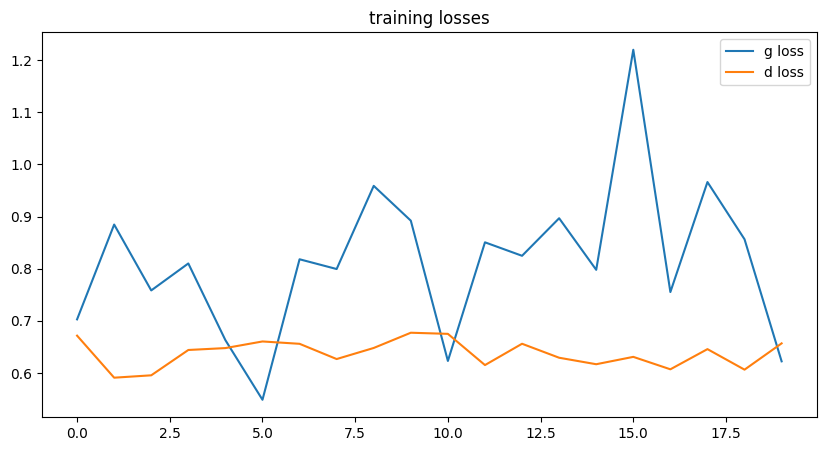

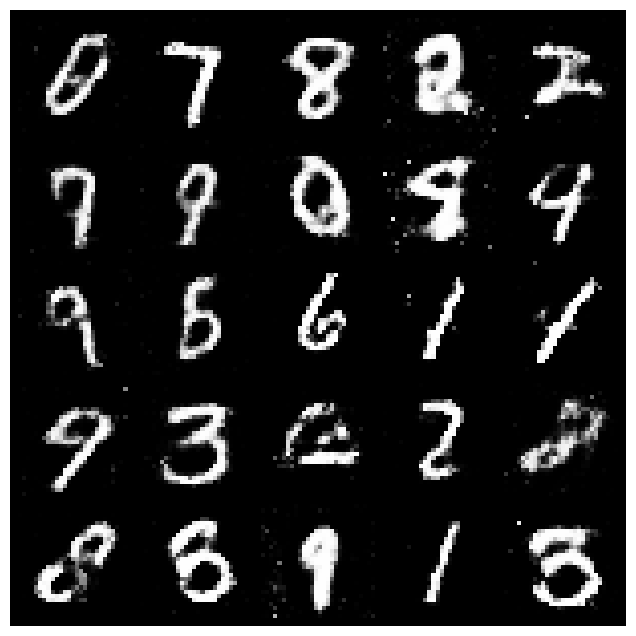

In [5]:

# train on mnist
gen_mnist, g_loss_mnist, d_loss_mnist = train_gan(loader_mnist, epochs=20, name="mnist")
plot_losses(g_loss_mnist, d_loss_mnist)
show_generated(gen_mnist)



## 2. conditional gan (cgan)


modifying generator and discriminator to accept class labels. training to generate specific digits/items.


In [6]:

class GeneratorcGAN(nn.Module):
    def __init__(self, latent_dim=100, n_classes=10):
        super(GeneratorcGAN, self).__init__()

        self.label_emb = nn.Embedding(n_classes, 10)

        self.model = nn.Sequential(
            nn.Linear(latent_dim + 10, 256),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        img = self.model(x)
        img = img.view(img.size(0), 1, 28, 28)
        return img

class DiscriminatorcGAN(nn.Module):
    def __init__(self, n_classes=10):
        super(DiscriminatorcGAN, self).__init__()

        self.label_emb = nn.Embedding(n_classes, 10)

        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_emb(labels)
        x = img.view(img.size(0), -1)
        x = torch.cat([x, c], 1)
        validity = self.model(x)
        return validity



In [ ]:

def train_cgan(loader, epochs=20):
    latent_dim = 100
    generator = GeneratorcGAN(latent_dim).to(device)
    discriminator = DiscriminatorcGAN().to(device)

    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    adversarial_loss = nn.BCELoss()

    print("training cgan...")

    for epoch in range(epochs):
        for i, (imgs, labels) in enumerate(loader):
            batch_size = imgs.size(0)
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            real_imgs = imgs.to(device)
            labels = labels.to(device)

            # train generator
            optimizer_g.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, 10, (batch_size,)).to(device)

            gen_imgs = generator(z, gen_labels)
            validity = discriminator(gen_imgs, gen_labels)

            g_loss = adversarial_loss(validity, valid)
            g_loss.backward()
            optimizer_g.step()

            # train discriminator
            optimizer_d.zero_grad()

            real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_d.step()

        print(f"epoch {epoch+1}/{epochs} [d loss: {d_loss.item():.4f}] [g loss: {g_loss.item():.4f}]")

    return generator


cgan_fashion = train_cgan(loader_fashion, epochs=20)


training cgan...
epoch 1/20 [d loss: 0.1936] [g loss: 3.3184]
epoch 2/20 [d loss: 0.5648] [g loss: 1.1662]
epoch 3/20 [d loss: 0.5828] [g loss: 0.7459]
epoch 4/20 [d loss: 0.6797] [g loss: 0.7915]
epoch 5/20 [d loss: 0.6606] [g loss: 0.8847]
epoch 6/20 [d loss: 0.6992] [g loss: 0.9497]
epoch 7/20 [d loss: 0.6419] [g loss: 0.7790]
epoch 8/20 [d loss: 0.6604] [g loss: 0.7422]
epoch 9/20 [d loss: 0.6751] [g loss: 0.7832]
epoch 10/20 [d loss: 0.6910] [g loss: 0.7340]
epoch 11/20 [d loss: 0.6870] [g loss: 0.8045]
epoch 12/20 [d loss: 0.6917] [g loss: 0.8006]
epoch 13/20 [d loss: 0.6927] [g loss: 0.7036]
epoch 14/20 [d loss: 0.6828] [g loss: 0.7294]
epoch 15/20 [d loss: 0.6805] [g loss: 0.6815]
epoch 16/20 [d loss: 0.6884] [g loss: 0.7187]
epoch 17/20 [d loss: 0.6998] [g loss: 0.7099]
epoch 18/20 [d loss: 0.6516] [g loss: 0.6963]
epoch 19/20 [d loss: 0.6760] [g loss: 0.6976]
epoch 20/20 [d loss: 0.6732] [g loss: 0.7110]


### generating specific classes


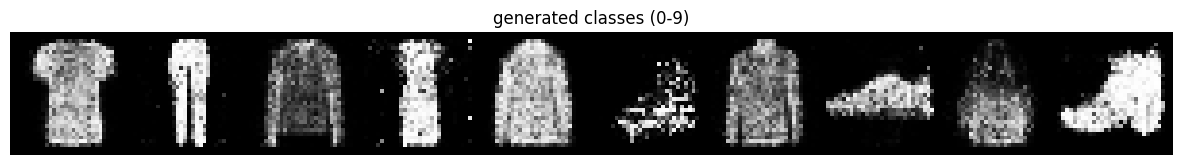

In [8]:

def show_class_generation(generator, n_classes=10):
    generator.eval()
    z = torch.randn(n_classes, 100).to(device)
    labels = torch.arange(n_classes).long().to(device)

    gen_imgs = generator(z, labels).cpu().detach()

    grid = torchvision.utils.make_grid(gen_imgs, nrow=10, normalize=True)
    plt.figure(figsize=(15,2))
    plt.imshow(grid.permute(1,2,0))
    plt.axis('off')
    plt.title("generated classes (0-9)")
    plt.show()

show_class_generation(cgan_fashion)



## 3. advanced techniques: feature matching


implementing feature matching loss to stabilize training.


training gan with feature matching (tuned)...
epoch 1/20 [d loss: 0.5642] [g loss: 0.1557]
epoch 2/20 [d loss: 0.5079] [g loss: 0.1217]
epoch 3/20 [d loss: 0.4706] [g loss: 0.1590]
epoch 4/20 [d loss: 0.2785] [g loss: 0.4495]
epoch 5/20 [d loss: 0.2822] [g loss: 0.5574]
epoch 6/20 [d loss: 0.4528] [g loss: 0.5260]
epoch 7/20 [d loss: 0.2637] [g loss: 0.9920]
epoch 8/20 [d loss: 0.1064] [g loss: 0.9261]
epoch 9/20 [d loss: 0.1628] [g loss: 0.8970]
epoch 10/20 [d loss: 0.2263] [g loss: 0.5107]
epoch 11/20 [d loss: 0.1665] [g loss: 1.3839]
epoch 12/20 [d loss: 0.3046] [g loss: 0.7242]
epoch 13/20 [d loss: 0.2349] [g loss: 1.0502]
epoch 14/20 [d loss: 0.1622] [g loss: 1.3476]
epoch 15/20 [d loss: 0.2300] [g loss: 1.5850]
epoch 16/20 [d loss: 0.2456] [g loss: 0.7972]
epoch 17/20 [d loss: 0.0884] [g loss: 1.1202]
epoch 18/20 [d loss: 0.1310] [g loss: 1.4281]
epoch 19/20 [d loss: 0.1454] [g loss: 1.2031]
epoch 20/20 [d loss: 0.0588] [g loss: 1.0183]


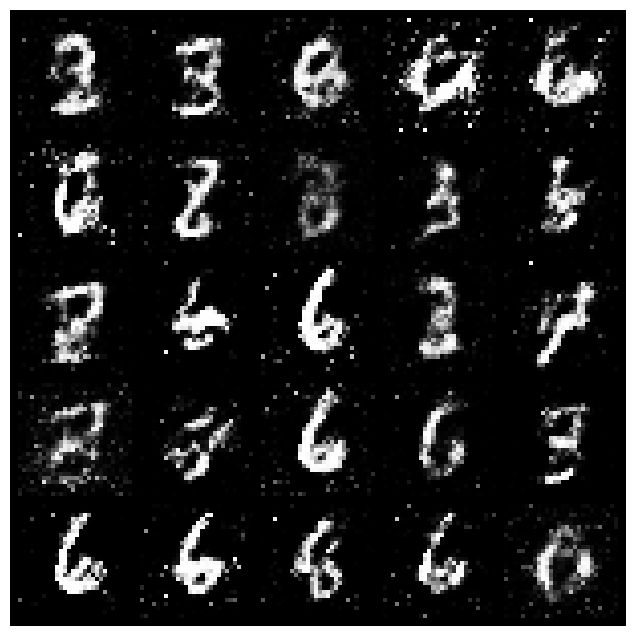

In [ ]:

class DiscriminatorFeatureMatching(nn.Module):
    def __init__(self):
        super(DiscriminatorFeatureMatching, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.output = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        feat1 = self.layer1(img)
        feat2 = self.layer2(feat1)
        validity = self.output(feat2)
        return validity, feat2

def train_gan_feature_matching(loader, epochs=20):
    latent_dim = 100
    generator = Generator(latent_dim).to(device)
    discriminator = DiscriminatorFeatureMatching().to(device)

    # reduced lr for discriminator to prevent overfitting
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

    adversarial_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()

    print("training gan with feature matching (tuned)...")

    for epoch in range(epochs):
        for i, (imgs, _) in enumerate(loader):
            batch_size = imgs.size(0)
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)
            real_imgs = imgs.to(device)

            #   train generator
            optimizer_g.zero_grad()
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_imgs = generator(z)

            # feature matching on deeper layer (layer2)
            _, real_feats = discriminator(real_imgs)
            _, fake_feats = discriminator(gen_imgs)

            g_loss = mse_loss(fake_feats, real_feats.detach())
            g_loss.backward()
            optimizer_g.step()

            #  discriminator
            optimizer_d.zero_grad()

            # adding noise to inputs to stabilize discriminator
            noise = torch.randn_like(real_imgs) * 0.1
            real_validity, _ = discriminator(real_imgs + noise)
            fake_validity, _ = discriminator(gen_imgs.detach() + noise)

            real_loss = adversarial_loss(real_validity, valid)
            fake_loss = adversarial_loss(fake_validity, fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_d.step()

        print(f"epoch {epoch+1}/{epochs} [d loss: {d_loss.item():.4f}] [g loss: {g_loss.item():.4f}]")

    return generator

# train with feature matching
gen_fm = train_gan_feature_matching(loader_mnist, epochs=20)
show_generated(gen_fm)

